## Applying Stochastic Methods
### Getting Started
This tutorial focuses on using stochastic methods to estimate ultimates. 

Note that a lot of the examples shown here might not be applicable in a real world scenario, and is only meant to demonstrate some of the functionalities included in the package. The user should always exercise their best actuarial judgement, and follow any applicable laws, the Code of Professional Conduct, and applicable Actuarial Standards of Practice.

Be sure to make sure your packages are updated. For more info on how to update your pakages, visit [Keeping Packages Updated](https://chainladder-python.readthedocs.io/en/latest/install.html#keeping-packages-updated).

In [1]:
# Black linter, optional
%load_ext lab_black

import pandas as pd
import numpy as np
import chainladder as cl
import matplotlib.pyplot as plt
import statsmodels.api as sm
import os

%matplotlib inline

print("pandas: " + pd.__version__)
print("numpy: " + np.__version__)
print("chainladder: " + cl.__version__)

pandas: 1.3.3
numpy: 1.20.3
chainladder: 0.8.9


### Intro to MackChainladder

Like the basic `Chainladder` method, the `MackChainladder` is entirely specified by its selected development pattern. In fact, it is the basic `Chainladder`, but with extra features.

In [2]:
clrd = (
    cl.load_sample("clrd")
    .groupby("LOB")
    .sum()
    .loc["wkcomp", ["CumPaidLoss", "EarnedPremNet"]]
)

cl.Chainladder().fit(clrd["CumPaidLoss"]).ultimate_ == cl.MackChainladder().fit(
    clrd["CumPaidLoss"]
).ultimate_

True

Let's create a Mack's Chainladder model.

In [3]:
mack = cl.MackChainladder().fit(clrd["CumPaidLoss"])

MackChainladder has the following additional fitted features that the deterministic `Chainladder` does not:

- `full_std_err_`:  The full standard error
- `total_process_risk_`: The total process error
- `total_parameter_risk_`: The total parameter error
- `mack_std_err_`: The total prediction error by origin period
- `total_mack_std_err_`: The total prediction error across all origin periods

Notice these are all measures of uncertainty, but where can they be applied? Let's start by examining the `link_ratios` underlying the triangle between age 12 and 24.

In [4]:
clrd_first_lags = clrd[clrd.development <= 24][clrd.origin < "1997"]["CumPaidLoss"]
clrd_first_lags

,12,24
1988,"285,804","638,532"
1989,"307,720","684,140"
1990,"320,124","757,479"
1991,"347,417","793,749"
1992,"342,982","781,402"
1993,"342,385","743,433"
1994,"351,060","750,392"
1995,"343,841","768,575"
1996,"381,484","736,040"


A simple average link-ratio can be directly computed.

In [5]:
clrd_first_lags.link_ratio.to_frame().mean()[0]

2.2066789527531494

We can also verify that the result is the same as the `Development` object.

In [6]:
cl.Development(average="simple").fit(clrd["CumPaidLoss"]).ldf_.to_frame().values[0, 0]

2.2066789527531494

### The Linear Regression Framework

Mack noted that the estimate for the LDF is really just a linear regression fit. In the case of using the `simple` average, it is a weighted regression where the weight is $\left (\frac{1}{X}  \right )^{2}$.

Let's take a look at the fitted coefficient and verify that this ties to the direct calculations that we made earlier.
With the regression framework in hand, we can get more information about our LDF estimate than just the coefficient.

In [7]:
y = clrd_first_lags.to_frame().values[:, 1]
x = clrd_first_lags.to_frame().values[:, 0]

model = sm.WLS(y, x, weights=(1 / x) ** 2)
results = model.fit()
results.summary()

C:\Users\jboga\anaconda3\envs\cl_docs\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 WLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.997
Model:                            WLS   Adj. R-squared (uncentered):              0.997
Method:                 Least Squares   F-statistic:                              2887.
Date:                Mon, 04 Oct 2021   Prob (F-statistic):                    1.60e-11
Time:                        06:55:46   Log-Likelihood:                         -107.89
No. Observations:                   9   AIC:                                      217.8
Df Residuals:                       8   BIC:                                      218.0
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.2067      0.041     53.735      0.000       2.112       2.301
==============================================================================
Omnibus:                        7.448   Durbin-Watson:                   1.177
Prob(Omnibus):                  0.024   Jarque-Bera (JB):                2.533
Skew:                          -1.187   Prob(JB):                        0.282
Kurtosis:                       4.058   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

By toggling the weights of our regression, we can handle the most common types of averaging used in picking loss development factors.
- For simple average, the weights are $\left (\frac{1}{X}  \right )^{2}$
- For volume-weighted average, the weights are $\left (\frac{1}{X}  \right )$
- For "regression" average, the weights are 1

In [8]:
print("Simple average:")
print(
    round(
        cl.Development(average="simple")
        .fit(clrd_first_lags)
        .ldf_.to_frame()
        .values[0, 0],
        10,
    )
    == round(sm.WLS(y, x, weights=(1 / x) ** 2).fit().params[0], 10)
)

print("Volume-weighted average:")
print(
    round(
        cl.Development(average="volume")
        .fit(clrd_first_lags)
        .ldf_.to_frame()
        .values[0, 0],
        10,
    )
    == round(sm.WLS(y, x, weights=(1 / x)).fit().params[0], 10)
)

print("Regression average:")
print(
    round(
        cl.Development(average="regression")
        .fit(clrd_first_lags)
        .ldf_.to_frame()
        .values[0, 0],
        10,
    )
    == round(sm.OLS(y, x, weights=1).fit().params[0], 10)
)

Simple average:
True
Volume-weighted average:
True
Regression average:
True


The regression framework is what the `Development` estimator uses to set development patterns. Although we discard the information in the deterministic methods, in the stochastic methods, `Development` has two useful statistics for estimating reserve variability, both of which come from the regression framework. The stastics are `sigma_` and `std_err_` , and they are used by the `MackChainladder` estimator to determine the prediction error of our reserves.

In [9]:
dev = cl.Development(average="simple").fit(clrd["CumPaidLoss"])

In [10]:
dev.sigma_

,12-24,24-36,36-48,48-60,60-72,72-84,84-96,96-108,108-120
(All),0.1232,0.0340,0.0135,0.0091,0.0074,0.0067,0.0073,0.0097,0.0032


In [11]:
dev.std_err_

,12-24,24-36,36-48,48-60,60-72,72-84,84-96,96-108,108-120
(All),0.0411,0.0120,0.0051,0.0037,0.0033,0.0033,0.0042,0.0068,0.0032


Remember that `std_err_` is calculated as $\frac{\sigma}{\sqrt{N}}$.

In [ ]:
np.round(
    dev.sigma_.to_frame().transpose()["(All)"].values
    / np.sqrt(clrd["CumPaidLoss"].age_to_age.to_frame().count()).values,
    4,
)

Since the regression framework uses the weighting method, we can easily turn "on and off" any observation we want using the dropping capabilities such as `drop_valuation` in the `Development` estimator. Dropping link ratios not only affects the `ldf_` and `cdf_`, but also the `std_err_` and `sigma` of the estimates.

Can we eliminate the 1988 valuation from our triangle, which is identical to eliminating the first observation from our 12-24 regression fit? Let's calculate the `std_err` for the `ldf_` of ages 12-24, and compare it to the value calculated using the weighted least squares regression.

In [ ]:
clrd["CumPaidLoss"]

In [ ]:
round(
    cl.Development(average="volume", drop_valuation="1988")
    .fit(clrd["CumPaidLoss"])
    .std_err_.to_frame()
    .values[0, 0],
    8,
) == round(sm.WLS(y[1:], x[1:], weights=(1 / x[1:])).fit().bse[0], 8)

With `sigma_` and `std_err_` in hand, Mack goes on to develop recursive formulas to estimate `parameter_risk_` and `process_risk_`.

In [ ]:
mack.parameter_risk_

In [ ]:
mack.process_risk_

### Assumption of Independence
The Mack model makes a lot of assumptions about independence (i.e. the covariance between random processes is 0). This means that many of the Variance estimates in the `MackChainladder` model follow the form of $Var(A+B) = Var(A)+Var(B)$. 

First, `mack_std_err_`<sup>2</sup> $=$ `parameter_risk_`<sup>2</sup> $+$ `process_risk_`<sup>2</sup>, the parameter risk and process risk is assumed to be independent. 

In [ ]:
mack.parameter_risk_ ** 2 + mack.process_risk_ ** 2

In [ ]:
mack.mack_std_err_ ** 2

Second, `total_process_risk_` <sup>2</sup> $= \sum_{origin} $ `process_risk_` <sup>2</sup>, the process risk is assumed to be independent between origins.

In [ ]:
mack.total_process_risk_ ** 2

In [ ]:
(mack.process_risk_ ** 2).sum(axis="origin")

Lastly, independence is also assumed to apply to the overall standard error of reserves, as expected.

In [ ]:
(mack.parameter_risk_ ** 2 + mack.process_risk_ ** 2).sum(axis=2).sum(axis=3)

In [ ]:
(mack.mack_std_err_ ** 2).sum(axis=2).sum(axis=3)

This over-reliance on independence is one of the weaknesses of the `MackChainladder` method. Nevertheless, if the data align with this assumption, then `total_mack_std_err_` is a reasonable esimator of reserve variability.

### Mack Reserve Variability
The `mack_std_err_` at ultimate is the reserve variability for each `origin` period.

In [ ]:
mack.mack_std_err_[
    mack.mack_std_err_.development == mack.mack_std_err_.development.max()
]

With the `summary_` method, we can more easily look at the result of the `MackChainladder` model.

In [ ]:
mack.summary_

Let's visualize the paid to date, the estimated reserves, and their standard errors with a histogram.

In [ ]:
plt.bar(
    mack.summary_.to_frame().index.year,
    mack.summary_.to_frame()["Latest"],
    label="Paid",
)
plt.bar(
    mack.summary_.to_frame().index.year,
    mack.summary_.to_frame()["IBNR"],
    bottom=mack.summary_.to_frame()["Latest"],
    yerr=mack.summary_.to_frame()["Mack Std Err"],
    label="Reserves",
)
plt.legend(loc="upper left")
plt.ylim(0, 1800000)

We can also simulate the (assumed) normally distributed IBNR with `np.random.normal()`.

In [ ]:
ibnr_mean = mack.ibnr_.sum()
ibnr_sd = mack.total_mack_std_err_.values[0, 0]
n_trials = 10000

np.random.seed(2021)
dist = np.random.normal(ibnr_mean, ibnr_sd, size=n_trials)

plt.hist(dist, bins=50)

### ODP Bootstrap Model
The `MackChainladder` focuses on a regression framework for determining the variability of reserve estimates. An alternative approach is to use the statistical bootstrapping, or sampling from a triangle with replacement to simulate new triangles.

Bootstrapping imposes less model constraints than the `MackChainladder`, which allows for greater applicability in different scenarios. Sampling new triangles can be accomplished through the `BootstrapODPSample` estimator. This estimator will take a single triangle and simulate new ones from it. To simulate new triangles randomly from an existing triangle, we specify `n_sims` with how many triangles we want to simulate, and access the `resampled_triangles_` attribute to get the simulated triangles. Notice that the shape of `resampled_triangles_` matches `n_sims` at the first index.

In [27]:
samples = (
    cl.BootstrapODPSample(n_sims=10000).fit(clrd["CumPaidLoss"]).resampled_triangles_
)
samples

,Triangle Summary
Valuation:,1997-12
Grain:,OYDY
Shape:,"(10000, 1, 10, 10)"
Index:,[LOB]
Columns:,[CumPaidLoss]


Alternatively, we could use `BootstrapODPSample` to transform our triangle into a resampled set.

The notion of the ODP Bootstrap is that as our simulations approach infinity, we should expect our mean simulation to converge on the basic `Chainladder` estimate of of reserves.

Let's apply the basic chainladder to our original triangle and also to our simulated triangles to see whether this holds true.

In [28]:
ibnr_cl = cl.Chainladder().fit(clrd["CumPaidLoss"]).ibnr_.sum()
ibnr_bootstrap = cl.Chainladder().fit(samples).ibnr_.sum("origin").mean()

print(
    "Chainladder's IBNR estimate:",
    ibnr_cl,
)
print(
    "BootstrapODPSample's mean IBNR estimate:",
    ibnr_bootstrap,
)
print("Difference $:", ibnr_cl - ibnr_bootstrap)
print("Difference %:", abs(ibnr_cl - ibnr_bootstrap) / ibnr_cl)

c:\users\jboga\documents\github\chainladder-python\chainladder\tails\base.py:120: RuntimeWarning: overflow encountered in exp
  sigma_ = xp.exp(time_pd * reg.slope_ + reg.intercept_)
c:\users\jboga\documents\github\chainladder-python\chainladder\tails\base.py:124: RuntimeWarning: overflow encountered in exp
  std_err_ = xp.exp(time_pd * reg.slope_ + reg.intercept_)


Chainladder's IBNR estimate: 2777812.6890986315
BootstrapODPSample's mean IBNR estimate: 2780090.932724299
Difference $: -2278.243625667412
Difference %: 0.0008201573974401693


### Using Deterministic Methods with Bootstrapped Samples
Our `samples` is just another triangle object with all the functionality of a regular triangle.  This means we can apply any functionality we want to our `samples` including any deterministic methods we learned about previously.

In [29]:
pipe = cl.Pipeline(
    [("dev", cl.Development(average="simple")), ("tail", cl.TailConstant(1.05))]
)
pipe.fit(samples)

Pipeline(steps=[('dev', Development(average='simple')),
                ('tail', TailConstant(tail=1.05))])

Now instead of a single `ldf_` (and `cdf_`) array across developmental ages, we have 10,000 arrays of `ldf_` (and `cdf_`).

In [30]:
pipe.named_steps.dev.ldf_.iloc[0]

,12-24,24-36,36-48,48-60,60-72,72-84,84-96,96-108,108-120
(All),2.2328,1.3222,1.1488,1.0793,1.0402,1.0348,1.0286,1.0201,1.0143


In [31]:
pipe.named_steps.dev.ldf_.iloc[1]

,12-24,24-36,36-48,48-60,60-72,72-84,84-96,96-108,108-120
(All),2.1475,1.3239,1.1657,1.0812,1.0437,1.0332,1.0331,1.0224,1.0105


In [32]:
pipe.named_steps.dev.ldf_.iloc[9999]

,12-24,24-36,36-48,48-60,60-72,72-84,84-96,96-108,108-120
(All),2.2236,1.2984,1.1500,1.0832,1.0468,1.0322,1.0251,1.0147,1.0097


This allows us to look at the varibility of any fitted property used. Let's look at the distribution of the age-to-age factor between age 12 and 24, and compare it against the LDF calculated from the non-bootstrapped triangle.

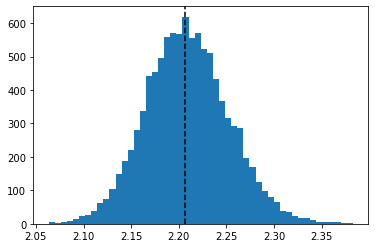

In [33]:
resampled_ldf = pipe.named_steps.dev.ldf_
plt.hist(pipe.named_steps.dev.ldf_.values[:, 0, 0, 0], bins=50)

orig_dev = cl.Development(average="simple").fit(clrd["CumPaidLoss"])
plt.axvline(orig_dev.ldf_.values[0, 0, 0, 0], color="black", linestyle="dashed")

### Bootstrap vs Mack
We can approximate some of the Mack's parameters calculated using the regression framework.

In [34]:
bootstrap_vs_mack = resampled_ldf.std("index").to_frame().T
bootstrap_vs_mack.rename(columns={"(All)": "Std_Bootstrap"}, inplace=True)
bootstrap_vs_mack = bootstrap_vs_mack.merge(
    orig_dev.std_err_.to_frame().T, left_index=True, right_index=True
)
bootstrap_vs_mack.rename(columns={"(All)": "Std_Mack"}, inplace=True)

bootstrap_vs_mack

,Std_Bootstrap,Std_Mack
12-24,0.043592,0.041066
24-36,0.012002,0.012024
36-48,0.007270,0.005101
48-60,0.005248,0.003734
60-72,0.004060,0.003303
72-84,0.003736,0.003337
84-96,0.003773,0.004190
96-108,0.004090,0.006831
108-120,0.004134,0.003222


([<matplotlib.axis.XTick at 0x22ad23b3580>,
 [Text(0, 0, '12-24'),
  Text(1, 0, '24-36'),
  Text(2, 0, '36-48'),
  Text(3, 0, '48-60'),
  Text(4, 0, '60-72'),
  Text(5, 0, '72-84'),
  Text(6, 0, '84-96'),
  Text(7, 0, '96-108'),
  Text(8, 0, '108-120')])

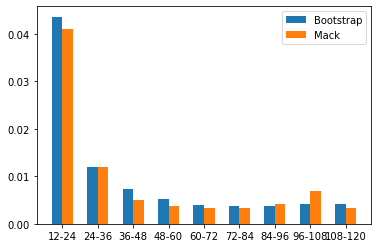

In [35]:
width = 0.3
ages = np.arange(len(bootstrap_vs_mack))

plt.bar(
    ages - width / 2,
    bootstrap_vs_mack["Std_Bootstrap"],
    width=width,
    label="Bootstrap",
)
plt.bar(ages + width / 2, bootstrap_vs_mack["Std_Mack"], width=width, label="Mack")
plt.legend(loc="upper right")
plt.xticks(ages, bootstrap_vs_mack.index)

While the `MackChainladder` produces statistics about the mean and variance of reserve estimates, the variance or precentile of reserves would need to be fited using maximum likelihood estimation or method of moments. However, for `BootstrapODPSample` based fits, we can use the empirical distribution from the samples directly to get information about variance or the precentile of the IBNR reserves.

In [36]:
ibnr = cl.Chainladder().fit(samples).ibnr_.sum("origin")

ibnr_std = ibnr.std()
print("Standard deviation of reserve estimate: " + f"{round(ibnr_std,0):,}")
ibnr_99 = ibnr.quantile(q=0.99)
print("99th percentile of reserve estimate: " + f"{round(ibnr_99,0):,}")

c:\users\jboga\documents\github\chainladder-python\chainladder\tails\base.py:120: RuntimeWarning: overflow encountered in exp
  sigma_ = xp.exp(time_pd * reg.slope_ + reg.intercept_)
c:\users\jboga\documents\github\chainladder-python\chainladder\tails\base.py:124: RuntimeWarning: overflow encountered in exp
  std_err_ = xp.exp(time_pd * reg.slope_ + reg.intercept_)


Standard deviation of reserve estimate: 138,134.0
99th percentile of reserve estimate: 3,099,203.0


Let's see how the `MackChainladder` reserve distribution compares to the `BootstrapODPSample` reserve distribution.

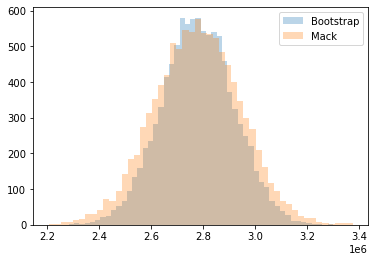

In [37]:
plt.hist(ibnr.to_frame(), bins=50, label="Bootstrap", alpha=0.3)
plt.hist(dist, bins=50, label="Mack", alpha=0.3)
plt.legend(loc="upper right")

### Bootstrapping with the Bornhuetter-Ferguson Method

So far, we've only applied the multiplicative methods (i.e. basic chainladder) in a stochastic context. It is possible to use an expected loss method like the `BornhuetterFerguson` method does. 

To do this, we will need an exposure vector.

In [38]:
clrd["EarnedPremNet"].latest_diagonal

,1997
1988,"1,691,130"
1989,"1,797,930"
1990,"1,880,315"
1991,"2,064,835"
1992,"2,189,448"
1993,"2,482,657"
1994,"2,594,787"
1995,"2,616,831"
1996,"2,420,655"
1997,"2,207,902"


Passing an `apriori_sigma` to the `BornhuetterFerguson` estimator tells it to consider the `apriori` selection itself as a random variable. Fitting a stochastic `BornhuetterFerguson` looks very much like the determinsitic version. Let's assume that the `apriori` is 80% (of `clrd["EarnedPremNet"]`) and its standard deviation is 10%.

In [39]:
bf = cl.BornhuetterFerguson(apriori=0.80, apriori_sigma=0.10)
bf.fit(samples, sample_weight=clrd["EarnedPremNet"].latest_diagonal)

c:\users\jboga\documents\github\chainladder-python\chainladder\tails\base.py:120: RuntimeWarning: overflow encountered in exp
  sigma_ = xp.exp(time_pd * reg.slope_ + reg.intercept_)
c:\users\jboga\documents\github\chainladder-python\chainladder\tails\base.py:124: RuntimeWarning: overflow encountered in exp
  std_err_ = xp.exp(time_pd * reg.slope_ + reg.intercept_)


BornhuetterFerguson(apriori=0.8, apriori_sigma=0.1)

Let's restate or sampled triangles so that the upper left portion of the triangle with known values. We will need to start with the `full_triangle_`, then take out the upper left (the simulated values) with `X_`, then add back the actual values from the raw triangle.

In [40]:
restated_triangle = bf.full_triangle_ - bf.X_ + clrd["CumPaidLoss"]

We can also look at how a certain origin period developed with the sampled triangles. Let's take a look at origin year 1995.

In [41]:
restated_triangle_1995_df = restated_triangle[
    restated_triangle.origin == "1995"
].to_frame()
restated_triangle_1995_df

development,12,24,36,48,60,72,84,96,108,120,132,9999
LOB,,,,,,,,,,,,
0,343841.0,768575.0,962081.0,1.118721e+06,1.259974e+06,1.335269e+06,1.404637e+06,1.462296e+06,1.504606e+06,1.535557e+06,1.535557e+06,1.535557e+06
1,343841.0,768575.0,962081.0,1.245910e+06,1.382030e+06,1.460546e+06,1.523705e+06,1.588105e+06,1.632745e+06,1.654334e+06,1.654334e+06,1.654334e+06
2,343841.0,768575.0,962081.0,1.171512e+06,1.321569e+06,1.405071e+06,1.457836e+06,1.519292e+06,1.556343e+06,1.567763e+06,1.567763e+06,1.567763e+06
3,343841.0,768575.0,962081.0,1.212013e+06,1.332455e+06,1.408233e+06,1.479991e+06,1.522399e+06,1.563065e+06,1.581438e+06,1.581438e+06,1.581438e+06
4,343841.0,768575.0,962081.0,1.111864e+06,1.222145e+06,1.296462e+06,1.352085e+06,1.400026e+06,1.444552e+06,1.474962e+06,1.474962e+06,1.474962e+06
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,343841.0,768575.0,962081.0,1.211480e+06,1.342681e+06,1.422638e+06,1.483089e+06,1.523686e+06,1.564560e+06,1.586594e+06,1.586594e+06,1.586594e+06
9996,343841.0,768575.0,962081.0,1.214500e+06,1.376062e+06,1.479236e+06,1.557799e+06,1.617848e+06,1.660140e+06,1.698227e+06,1.698227e+06,1.698227e+06
9997,343841.0,768575.0,962081.0,1.211762e+06,1.349311e+06,1.434123e+06,1.501612e+06,1.552997e+06,1.601928e+06,1.622163e+06,1.622163e+06,1.622163e+06


For simplicity, let's only graph the first 1,000 simulations. As expected, plotting the expected development of our full triangle over time from the Bootstrap `BornhuetterFerguson` model fans out to greater uncertainty the farther we get from our valuation date. And notice that for 1997 and prior (age 36 and prior), there is no variability as we have restated the simulated triangles with actual data.

([<matplotlib.axis.XTick at 0x22ad2610af0>,
 [Text(0, 0, '12'),
  Text(1, 0, '24'),
  Text(2, 0, '36'),
  Text(3, 0, '48'),
  Text(4, 0, '60'),
  Text(5, 0, '72'),
  Text(6, 0, '84'),
  Text(7, 0, '96'),
  Text(8, 0, '108'),
  Text(9, 0, '120'),
  Text(10, 0, '132'),
  Text(11, 0, 'Ult')])

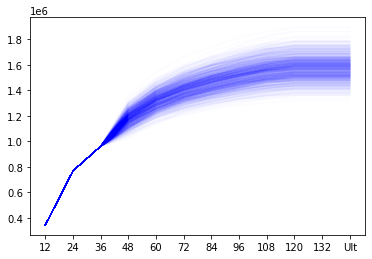

In [42]:
plt.plot(
    restated_triangle_1995_df.T.reset_index(drop=True).iloc[:, 0:1000],
    color="blue",
    alpha=0.01,
)
plt.xticks(
    np.arange(0, 12, 1),
    ["12", "24", "36", "48", "60", "72", "84", "96", "108", "120", "132", "Ult"],
)

### Recap
- The Mack method approaches stochastic reserving from a regression point of view
- Bootstrap methods approach stochastic reserving from a simulation point of view
- When the assumptions of the model are not violated, they will both produce resonably consistent estimates of reserve variability
- Mack does impose more assumptions (i.e. constraints) on the reserve estimate making the Bootstrap approach more suitable in a broader set of applciations
- Both methods converge to their corresponding deterministic point estimates